# A Tutorial on Sparsity via Regularisation 

This file is created as a trial of sparsity on a regression example. We consider a dataset with p features and n sample. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

In [232]:
import numpy as np
import matplotlib.pyplot as plt

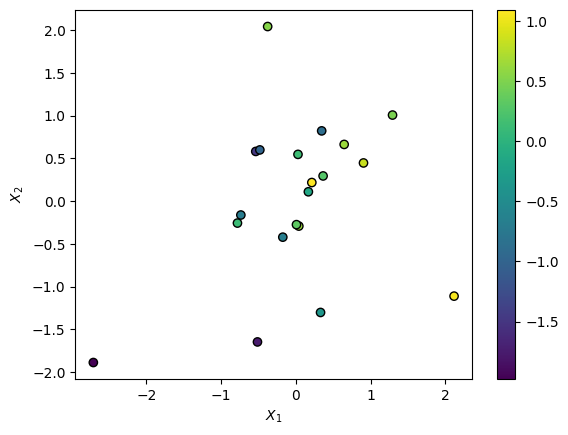

In [233]:
RNG = np.random.default_rng(seed=1)
p = 2
n = 20
var = 1
cov = var*np.eye(p)
mean = np.zeros(p)
sigma = 1

# To define the weights as beta
beta = np.array([1, 0]) 

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

# To show the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.colorbar()
plt.show()

The loss function also is defined as a squared norm of residuals as 

\begin{equation*}
Loss\;Function=\vert\vert X\beta - Y\vert\vert_2^2
\end{equation*}

In [234]:
# To define the loss function
# def squared_error(beta):
#     return np.linalg.norm(x.dot(np.atleast_2d(beta).T) - y.reshape(-1, 1), axis=0)**2

# To define another form of loss function
def squared_error(beta, x, y, d):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, d))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

In [235]:
# To check the loss function
squared_error(beta, x, y, p)

array([10.26943722])

Then we define a space of 2 dimensions for all probable $\beta \subset \mathcal{R}^2$ and calculate the loss function for this space. After that the residuals (errors) corresponding to the all $\beta$
estimation space and real output would be calculated.

In [236]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[0]
_beta2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta = np.reshape(_beta, (-1,2))

Now here we find the best estimated weights by least square optimization method.

In [237]:
# To define beta_hat by least square mathod
beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))
# least square in another calculation
# beta_hat = (np.linalg.inv(x.T@x)@x.T)@y
# beta_hat

Here we add a regularization (penalty/punishemnt) term to the loss function to sparse the solution space. It would be written as follows

\begin{equation*} 
Regularized\;Loss\;Function = \| X\beta - Y\|_2^2 + \alpha \|\beta \| 
\end{equation*}

The final goal is to obtain $\beta$ which minimize the regularized loss function. 

\begin{equation*} 
\hat{\beta} = \underset{\beta \in \mathcal{R}^2}{argmin} \; \| X\beta - Y\|_2^2 + \alpha\| \beta \|
\end{equation*}

Now we try to define the componentwise-penalty function as

\begin{equation*}
p(\beta) = \Bigg\{ 
    \begin{array}{rcl}
     |\beta| & if & \beta \le \frac{1}{2}\\
    |\beta-1 | & if & \beta > \frac{1}{2}\\
    \end{array} 
\end{equation*}

Text(0.5, 1.0, 'Componentwise-Penalty Function')

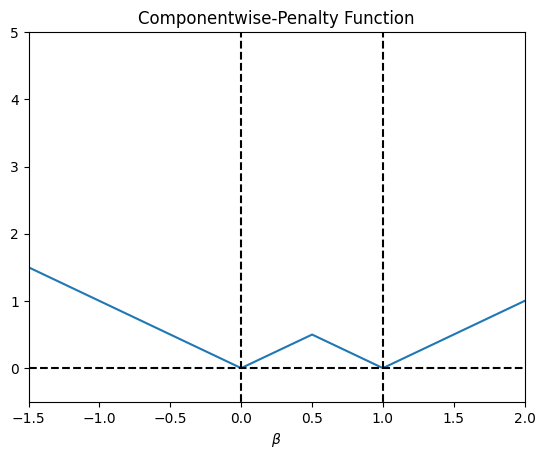

In [156]:
beta_range = np.linspace(-1.5, 2, 1000)
def penalty_function_order1(x):
    if x<=0.5:
      return abs(x)
    else:
      return abs(x-1)
fun = np.vectorize(penalty_function_order1)
penalty = fun(beta_range)

plt.plot(beta_range,penalty)
plt.vlines(0,-1,5,linestyles='--',colors='black')
plt.vlines(1,-1,5,linestyles='--',colors='black')
plt.hlines(0,-1.5,2,linestyles='--',colors='black')
plt.ylim([-0.5,5])
plt.xlim([-1.5,2])
plt.xlabel('$\\beta$')
plt.title('Componentwise-Penalty Function')
plt.title('Componentwise-Penalty Function')

In [345]:
from numpy.linalg import norm

# alpha=100
# def regularised_error(beta):
#     return squared_error(beta) + alpha*norm(np.atleast_2d(beta), 1, axis=1)

# To define the regularized loss function
def regularised_error(beta,alpha, x, y, d):
    return squared_error(beta, x, y, d) + alpha*np.sum(abs(np.reshape(beta,(-1,d))),axis=1)


In [346]:
# To define the regularized loss function with piecewise penalty term
# def sparsed_regularised_error(beta,alpha):
#     r = np.where(abs(beta)<=1, abs(beta), 0.5*beta**2+0.5)
#     return squared_error(beta) + alpha*np.sum(r)

# def sparsed_regularised_error(beta,alpha):
#     # p1 = np.where(abs(beta)<=0.5, abs(beta), beta**2+0.5)
#     # p2 = np.where(0.5<=any(beta)<=1.5, abs(beta-1), beta**2-1.75)
#     p = []
#     for b in beta:
#         if b<-0.5:
#             p.append(2*b**2)
#         elif abs(b)<=0.5:
#             p.append(abs(b))
#         elif b>=0.5 and b<=1.5:
#             p.append(abs(b-1))
#         else:
#             p.append(2*b**2-4)
#     return squared_error(beta) + alpha*np.sum(p)


def sparsed_regularised_error(beta,a , x, y, d):
  pp = []
  beta = np.reshape(beta,(-1, d))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(abs(b))
      else:
        p.append(abs(b-1))
    pp.append(a*np.sum(p))
  return squared_error(beta,x , y, d)+np.asarray(pp)

In [347]:
import scipy
from scipy.optimize import minimize
alpha=1
def minimizer(error_function, a, x, y, d):
    initial_beta = np.random.randint(2,size=(d))
    # initial_beta = np.array([0,0])
    # scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')
    result = minimize(error_function, initial_beta, method='Powell', args=(a, x, y, d), tol=1e-8)
    optimized_beta = result.x
    return optimized_beta
# scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')

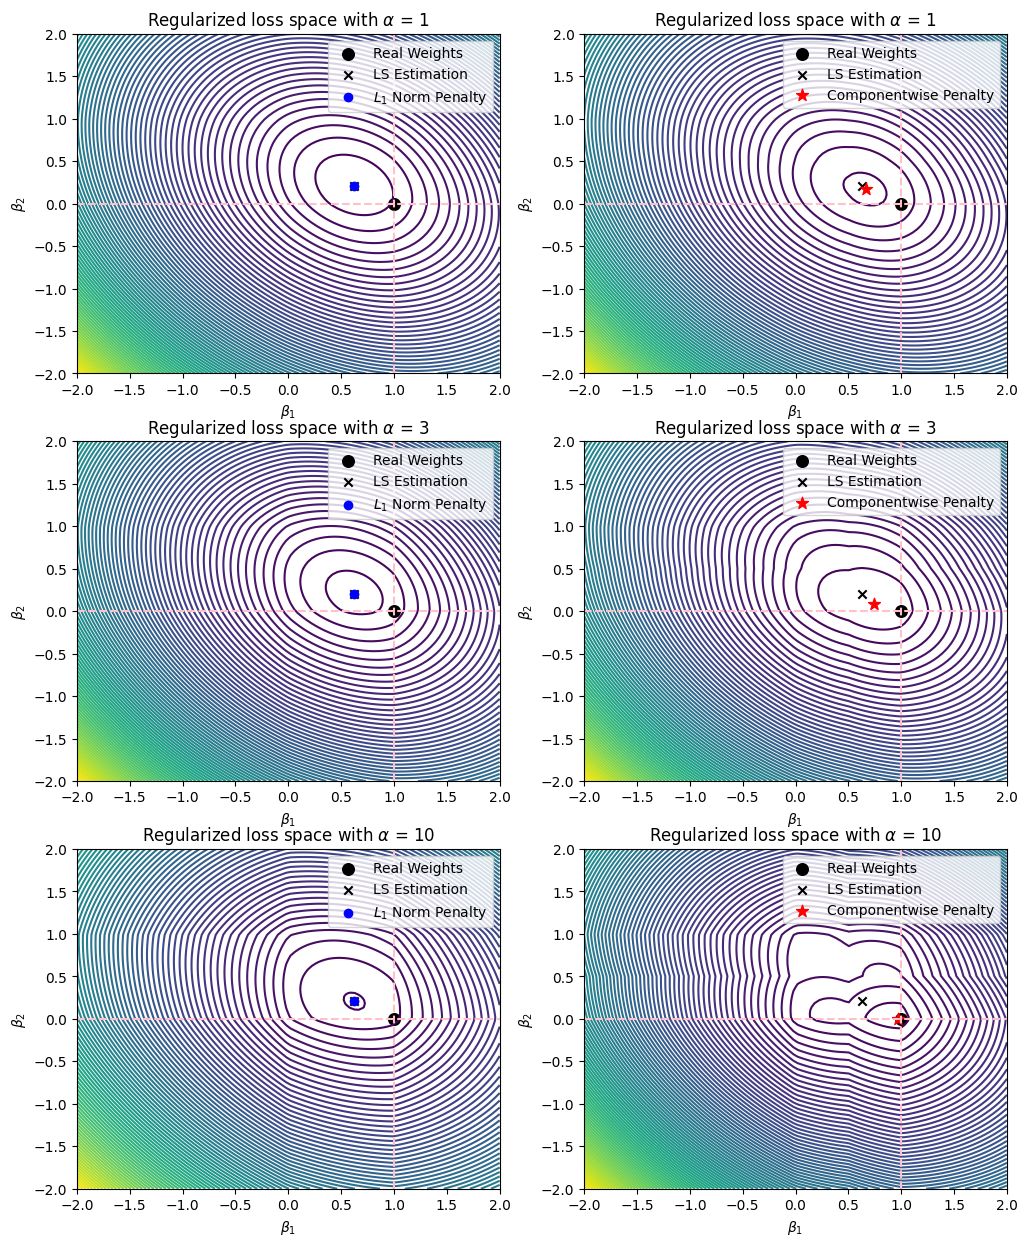

In [240]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(3, 2, figsize=(12, 15))

a = 1
axs[0,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[0,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[0,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[0,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[0,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0,0].scatter(minimizer(regularised_error, a, x, y, p)[0], minimizer(regularised_error, a, x, y, p)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
# axs[0,0].scatter(minimizer(sparsed_regularised_error, a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[0,0].set_xlabel('$\\beta_1$')
axs[0,0].set_ylabel('$\\beta_2$')
axs[0,0].legend()
axs[0,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[0,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[0,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[0,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[0,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[0,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[0,1].scatter(minimizer(regularised_error, a, x, y, p)[0], minimizer(regularised_error, a, x, y, p)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
axs[0,1].scatter(minimizer(sparsed_regularised_error, a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[0,1].set_xlabel('$\\beta_1$')
axs[0,1].set_ylabel('$\\beta_2$')
axs[0,1].legend()
axs[0,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))


a = 3
axs[1,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[1,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[1,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,0].scatter(minimizer(regularised_error, a, x, y, p)[0], minimizer(regularised_error, a, x, y, p)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
# axs[1,0].scatter(minimizer(sparsed_regularised_error, a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[1,0].set_xlabel('$\\beta_1$')
axs[1,0].set_ylabel('$\\beta_2$')
axs[1,0].legend()
axs[1,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[1,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[1,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[1,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[1,1].scatter(minimizer(regularised_error, a, x, y)[0], minimizer(regularised_error, a, x, y)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
axs[1,1].scatter(minimizer(sparsed_regularised_error, a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[1,1].set_xlabel('$\\beta_1$')
axs[1,1].set_ylabel('$\\beta_2$')
axs[1,1].legend()
axs[1,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))

a = 10
axs[2,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[2,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[2,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[2,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[2,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[2,0].scatter(minimizer(regularised_error, a, x, y, p)[0], minimizer(regularised_error, a, x, y, p)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
# axs[2,0].scatter(minimizer(sparsed_regularised_error,a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[2,0].set_xlabel('$\\beta_1$')
axs[2,0].set_ylabel('$\\beta_2$')
axs[2,0].legend()
axs[2,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[2,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta, a, x, y, p).reshape(100, 100), levels=100)
axs[2,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[2,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[2,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[2,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[2,1].scatter(minimizer(regularised_error, a, x, y, p)[0], minimizer(regularised_error, a, x, y, p)[1], marker='o', color='blue', label='$L_1$ Norm Penalty')
axs[2,1].scatter(minimizer(sparsed_regularised_error, a, x, y, p)[0], minimizer(sparsed_regularised_error, a, x, y, p)[1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[2,1].set_xlabel('$\\beta_1$')
axs[2,1].set_ylabel('$\\beta_2$')
axs[2,1].legend()
axs[2,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))



plt.show()

In [188]:
piecewise = []
traditional = []

for a in range(20):
    a = a + 1
    piecewise.append(minimizer(sparsed_regularised_error, a, x, y, p))
    traditional.append(minimizer(regularised_error, a, x, y, p))
piecewise_penalty = np.asarray(piecewise)
traditional_penalty = np.asarray(traditional)

(-0.2, 0.8)

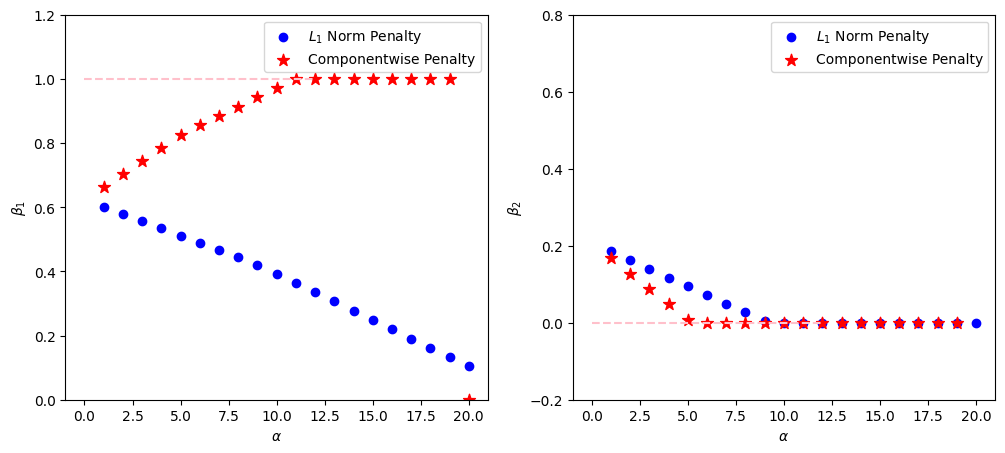

In [189]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 5))

alpha_range = np.asarray(range(20))+1

axs[0].hlines(1,0,12,linestyles='--',colors='pink')
axs[0].scatter(alpha_range, traditional_penalty[:,0], marker='o', color='blue', label='$L_1$ Norm Penalty')
axs[0].scatter(alpha_range, piecewise_penalty[:,0], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[0].set_xlabel('$\\alpha$')
axs[0].set_ylabel('$\\beta_1$')
axs[0].legend()
axs[0].set_ylim([0, 1.2])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

axs[1].hlines(0,0,12,linestyles='--',colors='pink')
axs[1].scatter(alpha_range, traditional_penalty[:,1], marker='o', color='blue', label='$L_1$ Norm Penalty')
axs[1].scatter(alpha_range, piecewise_penalty[:,1], marker='*', color='red', s=80, label='Componentwise Penalty')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('$\\beta_2$')
axs[1].legend()
axs[1].set_ylim([-0.2, 0.8])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

Lets to define the componentwise penalty function as

\begin{equation*}
p(\beta) = \Bigg\{ 
\begin{array}{rcl}
|\beta| & if & |\beta| \le \frac{1}{2}\\
|\beta-1 |& if & \frac{1}{2} < \beta \le \frac{3}{2}\\
(\beta-\frac{1}{2})^2-\frac{1}{2} & if & otherwise\\
\end{array} 
\end{equation*}

In [ ]:
beta_range = np.linspace(-1, 2, 1000)
def penalty_function_order2(x):
    if abs(x)<=0.5:
      return abs(x)
    elif x>0.5 and x<=1.5:
      return abs(x-1)
    # elif x<-0.5:
    #   return 2*(x-0.5)**2-1.5
    else:
      return (x-0.5)**2-0.5
fun = np.vectorize(penalty_function_order2)
penalty = fun(beta_range)

plt.plot(beta_range,penalty)
plt.vlines(0,-1,5,linestyles='--',colors='black')
plt.vlines(1,-1,5,linestyles='--',colors='black')
plt.hlines(0,-1.5,2,linestyles='--',colors='black')
plt.ylim([-0.5,2])
plt.xlim([-1,2])
plt.xlabel('$\\beta$')
plt.title('Componentwise Penalty Function')

In [177]:
def sparsed_regularised_error(beta,a, x, y, d):
  pp = []
  beta = np.reshape(beta,(-1, d))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if abs(b)<=0.5:
        p.append(abs(b))
      elif b>0.5 and b<=1.5:
        p.append(abs(b-1))
      else:
        p.append(2*(b-0.5)**2-1.5)
    pp.append(a*np.sum(p))
  return squared_error(beta, x, y, d)+np.asarray(pp)

In [180]:
piecewise = []
traditional = []

for a in range(20):
    a = a + 1
    piecewise.append(minimizer(sparsed_regularised_error,a, x, y, p))
    traditional.append(minimizer(regularised_error,a, x, y, p))
piecewise_penalty = np.asarray(piecewise)
traditional_penalty = np.asarray(traditional)


Here we make a change in our dataset: the number of samples and features are increased to 50 and 10. Then we repeat the approaches to see the performance of each penalty term on this new set of data.

(-0.1, 4.0)

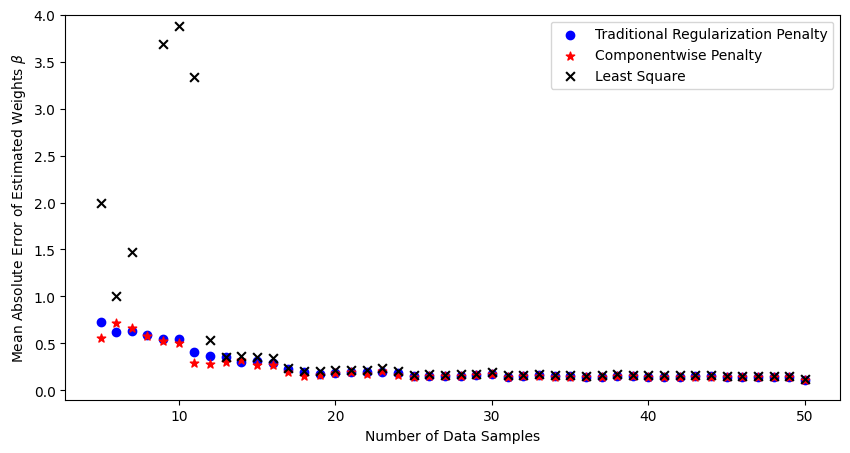

In [424]:
RNG = np.random.default_rng(seed=1)
d = 10
n = 50
var = 1
cov = var*np.eye(d)
mean = np.zeros(d)
sigma = 1

# To define the weights as beta
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))

estimated_beta_traditional = []
estimated_beta_piecewise = []
LS = []
N = []
a = 1
for i in range(len(x)-4):
  sample_size = i+5
  x_input = x[:sample_size]
  y_label = y[:sample_size]
  N.append(sample_size)
  LS.append(np.linalg.solve(x_input.T.dot(x_input), x_input.T.dot(y_label)))
  estimated_beta_traditional.append(minimizer(regularised_error, a, x_input, y_label, d))
  estimated_beta_piecewise.append(minimizer(sparsed_regularised_error, a, x_input, y_label, d))

mean_error_beta_traditional = np.mean(abs(beta-np.asarray(estimated_beta_traditional)),axis=1)
mean_error_beta_piecewise = np.mean(abs(beta-np.asarray(estimated_beta_piecewise)), axis=1)
mean_error_LS = np.mean(abs(beta-np.asarray(LS)), axis=1)
sample_number = np.asarray(N)


from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 1, figsize=(10, 5))
# axs.hlines(1,0,12,linestyles='--',colors='pink')
axs.scatter(sample_number, mean_error_beta_traditional, marker='o', color='blue', label='Traditional Regularization Penalty')
axs.scatter(sample_number, mean_error_beta_piecewise, marker='*', color='red', s=40, label='Componentwise Penalty')
axs.scatter(sample_number, mean_error_LS, marker='x', color='black', s=40, label='Least Square')
axs.set_xlabel('Number of Data Samples')
axs.set_ylabel('Mean Absolute Error of Estimated Weights $\\beta$')
axs.legend()
axs.set_ylim([-0.1, 4])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

In [509]:
import seaborn as sns
import pandas as pd

mean_abs_error_beta_traditional = np.mean(abs(beta-np.asarray(estimated_beta_traditional)),axis=1)

abs_error_beta_traditional = abs(beta-np.asarray(estimated_beta_traditional))
abs_error_beta_piecewise = abs(beta-np.asarray(estimated_beta_piecewise))

mat1 = []
mat2 = []
for n in range(46):
    mat1.append(abs_error_beta_traditional[n])
    mat2.append(abs_error_beta_piecewise[n])

err = pd.DataFrame(mat1)
sam = pd.DataFrame(sample_number)
df = pd.concat([sam, err], axis=1)
df.columns = ['sample','beta1','beta2','beta3','beta4','beta5','beta6','beta7','beta8','beta9','beta10']

fff=pd.concat([df['beta1'],df['beta2'],df['beta3'],df['beta4'],df['beta5'],df['beta6'],df['beta7'],df['beta8'],df['beta9'],df['beta10']], axis=0, keys=df['sample'])
# fig, ax = plt.subplots(1, sharex=False, sharey=False, gridspec_kw={'hspace': 0}, figsize=(10, 5))
# sns.boxplot(data=err,palette="PRGn")
fff

ValueError: Indexes have overlapping values: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
      dtype='int64')

# 82 octet binary semiconductors dataset

Now we try to compare the two sparsity approches on a dataset from properties of semiconductors.

In [ ]:
import pandas as pd

octet = pd.read_csv('octet.csv')
octet_selected = octet[['rp(A)', 'rp(B)', 'rs(A)']]
octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']

octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

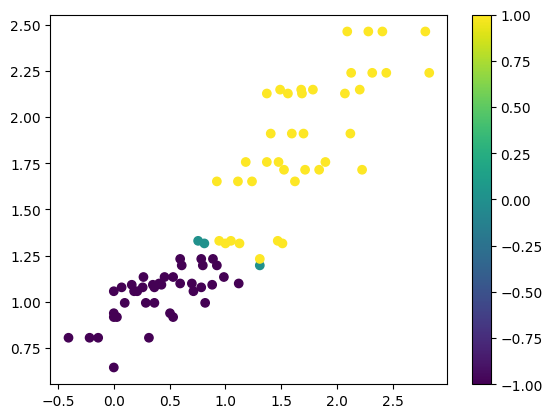

In [392]:
from matplotlib import pyplot as plt
# ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], octet_selected['RS_ZB'])
plt.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=octet_selected['RS_ZB'])
plt.colorbar()
plt.show()

In [393]:
prop = octet_selected[['sigma>0.91',	'sigma<-0.91',	'rs>1.22',	'sigma<1.16',	'sigma>-1.16',	'rs<1.27']]
label = octet_selected['RS_ZB']
x = octet_selected[['sigma', 'rs(A)']]
y = octet_selected['RS_ZB']

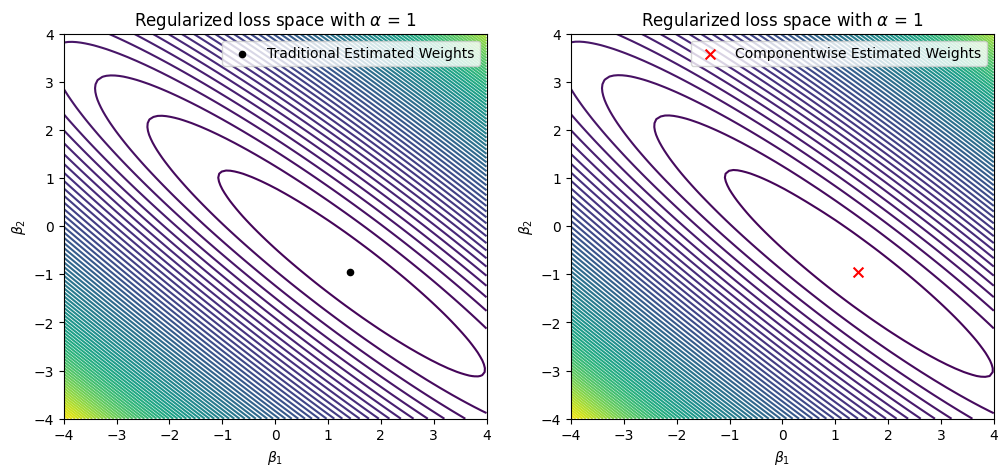

In [46]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))[0]
_beta2 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta = np.reshape(_beta, (-1,2))

a = 1
trad_estim = minimizer(sparsed_regularised_error,a, x=x, y=y, d=2)
compwise_estim = minimizer(regularised_error,a, x=x, y=y, d=2)

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), np.asarray(regularised_error(_beta, a, x, y, p)).reshape(100, 100), levels=100)
axs[0].scatter(trad_estim[0], trad_estim[1], marker='o', color='black', label='Traditional Estimated Weights', s=20)
axs[0].set_xlabel('$\\beta_1$')
axs[0].set_ylabel('$\\beta_2$')
axs[0].legend()
axs[0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), np.asarray(sparsed_regularised_error(_beta, a, x, y, p)).reshape(100, 100), levels=100)
axs[1].scatter(compwise_estim[0], compwise_estim[1], marker='x', color='red', label='Componentwise Estimated Weights', s=50)
axs[1].set_xlabel('$\\beta_1$')
axs[1].set_ylabel('$\\beta_2$')
axs[1].legend()
axs[1].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

In [408]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(40) * 100
center = np.ones(2) * 6
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center))
data

array([70.03673039, 74.27508094, 70.92800107, 56.67455225, 97.77853328,
       70.6334846 , 24.79157587, 15.78833509, 69.76985214, 71.99566667,
       25.77444303, 34.15467831, 96.87611677, 69.45070978, 46.63832593,
       70.28126954, 51.1785874 , 92.874137  , 73.97692989, 62.24390337,
       65.15454689, 39.68076115, 54.32393949, 79.98995282, 72.15447266,
       29.53639811, 16.09458806, 20.61255148, 13.43253868, 48.06050174,
       34.25218134, 36.29692901, 97.29176387, 11.09436116, 38.82640891,
       78.30658753, 97.28972601, 48.32096053, 33.64211054, 56.74190362,
        6.        ,  6.        ])

{'whiskers': [<matplotlib.lines.Line2D at 0x2968302b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2968307f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29634ffd0>],
 'medians': [<matplotlib.lines.Line2D at 0x296830cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x296830f70>],
 'means': []}

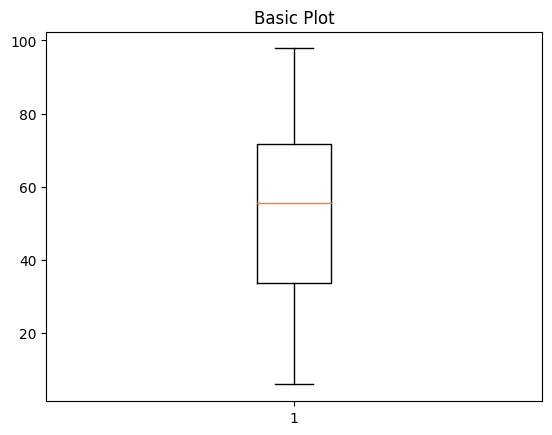

In [409]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)